In [3]:

import matplotlib.pyplot as plt
import numpy as np
import torch

from botorch import fit_gpytorch_model
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.optim.optimize import optimize_acqf
from botorch.models.gp_regression import SingleTaskGP
from botorch.sampling import SobolQMCNormalSampler
from botorch.acquisition import qExpectedImprovement

In [4]:
# In pytorch we deal with tensors which at this point you can just think of as pytorch equivalent of numpy arrays
# Setting up a global variable tkwargs which has the information of which CPU or GPU
# to initialize the tensors on.
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    tkwargs = {
        "dtype": torch.double,
        "device": torch.cuda.current_device(),}
else:
    tkwargs = {
        "dtype": torch.double,
        "device": torch.device("cpu"),}

In [5]:
# This function generates some random initial data that we use to start the optimization. The args are the input dimension
# of the problem, the number of initial points.
def generate_initial_data(dim_x,points):
    train_x=np.random.rand(points,dim_x)
    train_x=torch.from_numpy(train_x)
    train_x=train_x.to(**tkwargs)
    train_obj=problem(train_x)
    return train_x, train_obj

In [6]:
# This function models our objective function. It generates a GP and then marginal log likelihood of it that is used as a
# criteria of how good the GP models our data.
def initialize_model(train_x, train_obj):

    model = SingleTaskGP(
        train_x,
        train_obj,
        outcome_transform=Standardize(m=train_obj.shape[-1])
    )
    #model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-1)) # Only use if you want to add aritificial noise
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

# This is a helper function that deals with converting numpy to tensor arrays and calling the objective function
# Here we simply use a Forrester function defined below.
def problem(x):
    X=x.cpu()
    X=X.numpy()
    print('Sim Input',X)
    y=np.zeros((X.shape[0],1))
    y = np.apply_along_axis(forrester, 1, X)
    y_out=torch.from_numpy(y).to(**tkwargs)
    print('Sim Output MO',y_out)
    return y_out


def forrester(x):
    val=-((6 * x - 2)**2 * np.sin(12 * x - 4) + 7.025)
    return val

def Sinc(x):
    x = 50*(x-0.5)
    val=np.sin(x)/x
    return val

In [7]:
# This is a helper function that calls the qEI acquisition function and then optimizes this acquisition function
# The input parameters at which qEI is maximized would be the input parameters where we would call our objective function next.
def optimize_qEI_and_get_observation(model,bounds,train_obj,BATCH_SIZE):
    """Optimizes LCB and returns a new candidate, observation, and cost."""
    best_value = train_obj.max()
    # sampler = SobolQMCNormalSampler(sample_shape=torch.Size([512]), seed=0)   # This is the new botorch version syntax
    sampler = SobolQMCNormalSampler(num_samples=512, seed=0)                  # This is the old botorch version syntax
    qEI= qExpectedImprovement(model, best_f=best_value, sampler=sampler)

    candidates, acq_value = optimize_acqf(
        acq_function=qEI,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=10,
        raw_samples=512,
        options={"batch_limit": 5, "maxiter": 200},
    )

    new_x = candidates.detach()
    new_obj= problem(new_x)
    return new_x, new_obj

In [8]:
# Setting variables
dim_x=1
dim_y=1
n_TRIALS = 1  # Number of trials to run
n_BATCH = 15  # Number of iterations in one trial
BATCH_SIZE = 1 # Number of parallel evaluations
n_INIT = 2     # Number of initial points
standard_bounds = torch.tensor([[0.0] * dim_x, [1.0] * dim_x], **tkwargs) # the bounds of the problem
# The bounds constrain our input parameters to be within a certain range.


In [9]:
# Running Opt
# Defining arrays that would have the input and output data.
train_x = torch.zeros(n_INIT+n_BATCH,dim_x,n_TRIALS).to(**tkwargs)
train_obj = torch.zeros(n_INIT+n_BATCH,dim_y,n_TRIALS).to(**tkwargs)

for trial in range(0, n_TRIALS):
    torch.manual_seed(trial)
    print('***************************************************************************')
    print('Trial is ',trial)
    # Generating initial data and training the model.
    train_x[:n_INIT,:,trial], train_obj[:n_INIT,:,trial] = generate_initial_data(dim_x,n_INIT)
    mll, model = initialize_model(train_x[:n_INIT,:,trial], train_obj[:n_INIT,:,trial])
    # run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(0, n_BATCH ):
            print('----------------------------')
            print('Iteration Number is ',iteration+1)

            # fit the models
            fit_gpytorch_model(mll)
            # optimize acquisition functions and get new observations
            new_x,new_obj= optimize_qEI_and_get_observation(
                model,standard_bounds,train_obj,BATCH_SIZE)
            # Storing new values
            train_x[n_INIT+iteration,:,trial]=new_x
            train_obj[n_INIT+iteration,:,trial]=new_obj
            # reinitialize the models so they are ready for fitting on next iteration
            mll, model = initialize_model(train_x[:n_INIT+iteration,:,trial], train_obj[:n_INIT+iteration,:,trial])
# Converting tensors to numpy arrays again
train_x=train_x.cpu().numpy()
train_obj=train_obj.cpu().numpy()

***************************************************************************
Trial is  0
Sim Input [[0.1293753 ]
 [0.33634089]]
Sim Output MO tensor([[-6.0670],
        [-7.0250]], device='cuda:0', dtype=torch.float64)
----------------------------
Iteration Number is  1
Sim Input [[0.91507114]]
Sim Output MO tensor([[-14.8518]], device='cuda:0', dtype=torch.float64)
----------------------------
Iteration Number is  2
Sim Input [[0.54394377]]
Sim Output MO tensor([[-7.9454]], device='cuda:0', dtype=torch.float64)
----------------------------
Iteration Number is  3
Sim Input [[0.]]
Sim Output MO tensor([[-10.0522]], device='cuda:0', dtype=torch.float64)
----------------------------
Iteration Number is  4
Sim Input [[0.50660413]]
Sim Output MO tensor([[-7.9691]], device='cuda:0', dtype=torch.float64)
----------------------------
Iteration Number is  5
Sim Input [[0.21831306]]
Sim Output MO tensor([[-6.5574]], device='cuda:0', dtype=torch.float64)
----------------------------
Iteration Numb

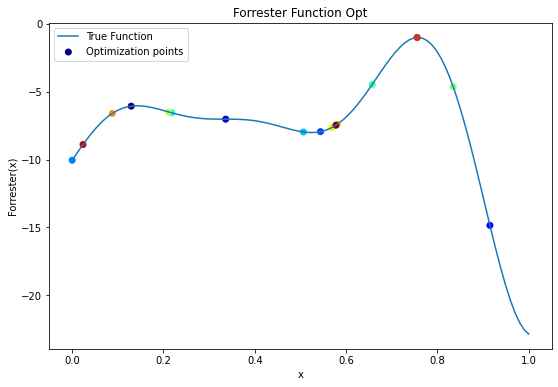

In [10]:
# Generating the True function
x = np.linspace(0,1,100)
y = forrester(x)

# The points are colored according to the sequence they were chosen during the optimization.
import matplotlib.cm as cm
c = cm.jet(np.linspace(0,1,n_BATCH+n_INIT))
fig, axes = plt.subplots(1, 1, figsize=(9, 6))
axes.plot(x,y,label='True Function')
axes.scatter(train_x[:,:,0],train_obj[:,:,0],marker='o',color=c,label='Optimization points')
axes.set_title('Forrester Function Opt')
axes.set_ylabel('Forrester(x)')
axes.set_xlabel('x')
axes.legend()

In [11]:
# Redefining the problem to optimize a Sinc function instead of a forrester function.
n_BATCH = 30


def problem(x):
    X=x.cpu()
    X=X.numpy()
    print('Sim Input',X)
    y=np.zeros((X.shape[0],1))
    y = np.apply_along_axis(Sinc, 1, X)
    y_out=torch.from_numpy(y).to(**tkwargs)
    print('Sim Output MO',y_out)
    return y_out


In [12]:
# Running Opt
# Defining arrays that would have the input and output data.
train_x=torch.zeros(n_INIT+n_BATCH,dim_x,n_TRIALS).to(**tkwargs)
train_obj=torch.zeros(n_INIT+n_BATCH,dim_y,n_TRIALS).to(**tkwargs)

for trial in range(0, n_TRIALS):
    torch.manual_seed(trial)
    print('***************************************************************************')
    print('Trial is ',trial)
    # Generating initial data and training the model.
    train_x[:n_INIT,:,trial], train_obj[:n_INIT,:,trial] = generate_initial_data(dim_x,n_INIT)
    mll, model = initialize_model(train_x[:n_INIT,:,trial], train_obj[:n_INIT,:,trial])
    # run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(0, n_BATCH ):
            print('----------------------------')
            print('Iteration Number is ',iteration+1)

            # fit the models
            fit_gpytorch_model(mll)
            # optimize acquisition functions and get new observations
            new_x,new_obj= optimize_qEI_and_get_observation(
                model,standard_bounds,train_obj,BATCH_SIZE)
            # Storing new values
            train_x[n_INIT+iteration,:,trial]=new_x
            train_obj[n_INIT+iteration,:,trial]=new_obj
            # reinitialize the models so they are ready for fitting on next iteration
            mll, model = initialize_model(train_x[:n_INIT+iteration,:,trial], train_obj[:n_INIT+iteration,:,trial])
# Converting tensors to numpy arrays again
train_x=train_x.cpu().numpy()
train_obj=train_obj.cpu().numpy()


***************************************************************************
Trial is  0
Sim Input [[0.37627702]
 [0.10514987]]
Sim Output MO tensor([[-0.0157],
        [ 0.0395]], device='cuda:0', dtype=torch.float64)
----------------------------
Iteration Number is  1
Sim Input [[1.]]
Sim Output MO tensor([[-0.0053]], device='cuda:0', dtype=torch.float64)
----------------------------
Iteration Number is  2
Sim Input [[1.]]
Sim Output MO tensor([[-0.0053]], device='cuda:0', dtype=torch.float64)
----------------------------
Iteration Number is  3
Sim Input [[0.]]
Sim Output MO tensor([[-0.0053]], device='cuda:0', dtype=torch.float64)
----------------------------
Iteration Number is  4
Sim Input [[0.]]
Sim Output MO tensor([[-0.0053]], device='cuda:0', dtype=torch.float64)
----------------------------
Iteration Number is  5
Sim Input [[0.16378453]]
Sim Output MO tensor([[-0.0531]], device='cuda:0', dtype=torch.float64)
----------------------------
Iteration Number is  6
Sim Input [[0.162

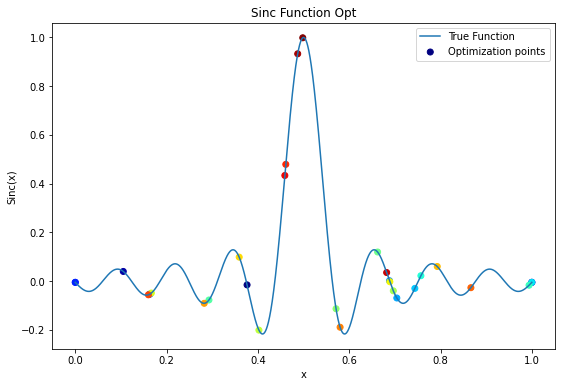

In [14]:
# Generating the True function
x = np.linspace(0,1,10000)
y2 = Sinc(x)

# The points are colored according to the sequence they were chosen during the optimization.
import matplotlib.cm as cm
c = cm.jet(np.linspace(0,1,n_BATCH+n_INIT))
fig, axes = plt.subplots(1, 1, figsize=(9, 6))
axes.plot(x,y2,label='True Function')
axes.scatter(train_x[:,:,0],train_obj[:,:,0],marker='o',color=c,label='Optimization points')
axes.set_title('Sinc Function Opt')
axes.set_ylabel('Sinc(x)')
axes.set_xlabel('x')
axes.legend()